In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
import time
from sklearn.model_selection import train_test_split
import seaborn as sns
from rdkit.Chem import Draw

In [23]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.test_size = 0.2
args.shuffle = True

np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
label_fs = 24
legend_fs = 14
ticks_fs = 18
marker_s = 12
ap = 0.4

In [24]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals
 

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        return len(l)
 
 
possible_atom_list = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Mg', 'Na', 'Br', 
                      'Fe', 'Ca', 'Cu', 'Mc', 'Pd', 'Pb', 'K', 'I', 'Al', 'Ni', 'Mn']
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                               Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                               Chem.rdchem.HybridizationType.SP3D2]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']

reference_lists = [possible_atom_list, possible_numH_list, possible_valence_list,
                   possible_formal_charge_list, possible_number_radical_e_list,
                   possible_hybridization_list, possible_chirality_list]
 
intervals = get_intervals(reference_lists)
 
def get_feature_list(atom):
    features = 6 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
    features[4] = safe_index(possible_number_radical_e_list,atom.GetNumRadicalElectrons())
    features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features
 
def features_to_id(features, intervals):
    """Convert list of features into index using spacings provided in intervals"""
    id = 0
    for k in range(len(intervals)):
        id += features[k] * intervals[k]
    # Allow 0 index to correspond to null molecule 1
    id = id + 1
    return id

def id_to_features(id, intervals):
    features = 6 * [0]
 
    # Correct for null
    id -= 1
 
    for k in range(0, 6 - 1):
        # print(6-k-1, id)
        features[6 - k - 1] = id // intervals[6 - k - 1]
        id -= features[6 - k - 1] * intervals[6 - k - 1]
    # Correct for last one
    features[0] = id
    return features
 
def atom_to_id(atom):
    """Return a unique id corresponding to the atom type"""
    features = get_feature_list(atom)
    return features_to_id(features, intervals)
 
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        from rdkit import Chem
        results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C','N','O','S','F','Si','P','Cl','Br','Mg',
                                                                   'Na','Ca','Fe','As','Al','I','B','V','K','Tl',
                                                                   'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H',  # H?
                                                                   'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr',
                                                                   'Pt','Hg','Pb','Unknown']) + 
                           one_of_k_encoding(atom.GetDegree(),[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + 
                           [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), [Chem.rdchem.HybridizationType.SP, 
                                                                           Chem.rdchem.HybridizationType.SP2, 
                                                                           Chem.rdchem.HybridizationType.SP3, 
                                                                           Chem.rdchem.HybridizationType.SP3D, 
                                                                           Chem.rdchem.HybridizationType.SP3D2]) + 
                           [atom.GetIsAromatic()])
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),[0, 1, 2, 3, 4]))
    if use_chirality:
        try:
            results = np.array(results.tolist() + 
                               one_of_k_encoding_unk(atom.GetProp('_CIPCode'),['R', 'S']) + 
                               [atom.HasProp('_ChiralityPossible')])
        except:
            results = np.array(results.tolist() + 
                               [False, False] + 
                               [atom.HasProp('_ChiralityPossible')])
 
    return np.array(results)
 
def bond_features(bond, use_chirality=False):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),
                  bond.IsInRing()]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),
                                                        ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res
 
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr,dtype=torch.float))
    return data

In [25]:
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['SMILES'].iloc[i])] = df['Affinity'].iloc[i]
    return mols

In [26]:
def make_vec(mols):
    X = [mol2vec(m) for m in mols.keys()]
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.float)
    return X

In [27]:
def df_check(df):
    df['mol2vec'] = 'Yes'
    for i in range(df.shape[0]):
        try:
            m = Chem.MolFromSmiles(df['SMILES'].iloc[i])
            vec = mol2vec(m)
    #         print(i, m, vec)
        except:
            df['mol2vec'].iloc[i] = 'No'
    #         print('No')
            continue

    df = df[df['mol2vec'] != 'No'].sample(frac=1).reset_index(drop=True)
    del df['mol2vec']
    return df

In [28]:
df1 = pd.read_csv('df_drugbank_smiles.csv')
df2 = pd.read_csv('drugbank_docking_affinity_results.csv')
df2['SMILES'] = None
for i in range(df2.shape[0]):
    dbid = df2['DrugBank ID'].iloc[i]
    df2['SMILES'].iloc[i] = list(df1[df1['drugbank_id'] == dbid]['smiles'])[0]
del df2['Compound']
df = df2[['DrugBank ID', 'SMILES', 'Affinity']]
df = df.sort_values(['Affinity'], ascending=False).reset_index(drop=True)
df = df[df['Affinity'] < 0].reset_index(drop=True)
df = df.drop_duplicates(['SMILES'], keep='first').reset_index(drop=True)
df = df_check(df)
df

/home/mhlee/anaconda3/envs/mhlee/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/mhlee/anaconda3/envs/mhlee/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,DrugBank ID,SMILES,Affinity
0,DB08559,[H][C@@]1(NC(=O)CC2=CC=CC=C2)C(=O)[N@]2[C@]1([...,-7.2
1,DB08686,[H][C@](CC)(C1=CC=CC=C1)C1=C(O)C2=C(CCCCCC2)OC1=O,-7.1
2,DB08677,CC(C)C1=CN\C(S1)=N\C(=O)CC1=CC=CN=C1,-6.4
3,DB01450,[H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H...,-7.8
4,DB04546,NC1=NC=CC2=C1N=CN2[C@@H]1O[C@@H](CO)[C@H](O)[C...,-6.6
...,...,...,...
4712,DB05248,NC1=NC(=O)N(C=C1Br)[C@@H]1O[C@H](COP(O)(O)=O)[...,-5.9
4713,DB07022,NC(=N)C1=CC2=C(NC(=O)C3=CC=CC(=C3)S(=O)(=O)OCC...,-7.5
4714,DB03649,OP(O)(=O)C(NC1=CC=C(Cl)C=N1)P(O)(O)=O,-5.7
4715,DB06866,[H][C@](CCCCC(N)=N)(C(O)=O)[C@@]1([H])C2=C(C[C...,-7.1


In [29]:
# df.to_excel('6yb7_binding_affinity.xlsx', index=False)

In [47]:
df = pd.read_excel('6yb7_binding_affinity.xlsx')
df = df.sort_values(['Affinity'], ascending=False).reset_index(drop=True)
df = df[df['Affinity'] < 0].reset_index(drop=True)
df = df.drop_duplicates(['SMILES'], keep='first').reset_index(drop=True)
df = df_check(df)
df

,DrugBank ID,SMILES,Affinity
0,DB00576,CC1=NN=C(NS(=O)(=O)C2=CC=C(N)C=C2)S1,-6.9
1,DB07353,[H][C@](N)(O)CC[C@@]([H])(N)CC1=CC=C(O)C=C1,-5.9
2,DB04556,[H][C@@](C)(N(C)C)C1=CC(O)=CC=C1,-5.1
3,DB01145,OS(=O)CNC1=CC=C(C=C1)S(=O)(=O)C1=CC=C(NCS(O)=O...,-7.0
4,DB03020,NC(=O)C1=C[NH+]=CC(=C1)[C@@H]1O[C@@H](CO[P@]([...,-7.2
...,...,...,...
4712,DB04693,C[C@]12CC[C@H]3[C@@H](CC[C@H]4CC(=O)CC[C@H]34)...,-7.5
4713,DB08394,OC(=O)CNC(=O)CCC[P@](O)(=O)OC1=CC=C(C=C1)[N+](...,-6.4
4714,DB07504,[H][C@](O)(COC1=CC=C(NC2=NC(NC3=CC=CC=C3)=C(Br...,-7.1
4715,DB01233,CCN(CC)CCNC(=O)C1=CC(Cl)=C(N)C=C1OC,-5.7


In [48]:
mols = []
for i in range(df.shape[0]):
    smi = df['SMILES'].iloc[i]
    m = Chem.MolFromSmiles(smi)
    mols.append(m)

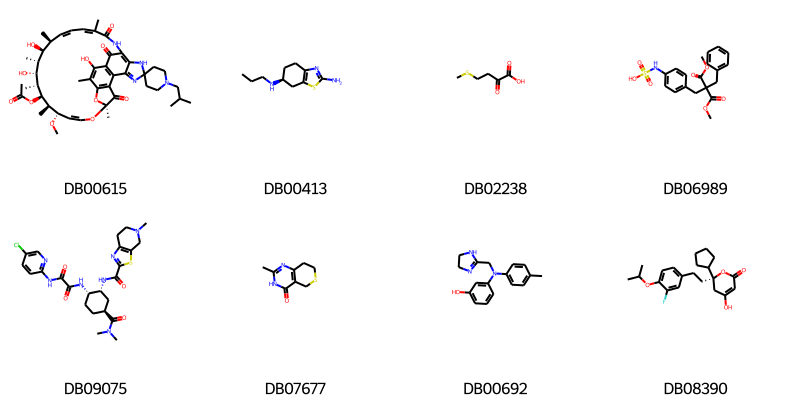

In [49]:
Draw.MolsToGridImage(mols[20:28], molsPerRow=4, legends=[x for x in df['DrugBank ID'][20:28]])

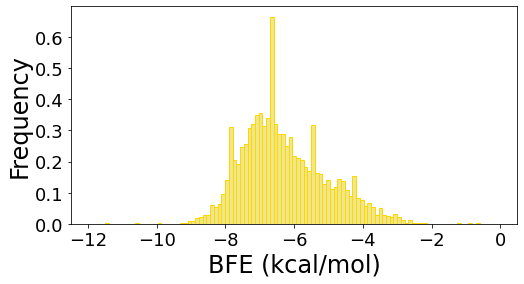

In [50]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.hist(df['Affinity'], bins=100, density=True, color='khaki', edgecolor='gold')
plt.xlabel('BFE (kcal/mol)', fontsize=label_fs)
plt.ylabel('Frequency', fontsize=label_fs)
plt.xlim([-12.5, 0.5])
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.show()

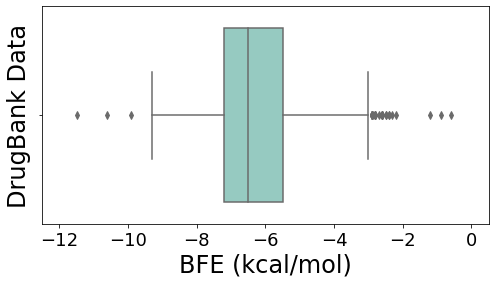

In [51]:
plt.rcParams["figure.figsize"] = (8, 4)
sns.boxplot(x=df['Affinity'], data=df, palette='Set3')
plt.xlabel('BFE (kcal/mol)', fontsize=label_fs)
plt.ylabel('DrugBank Data', fontsize=label_fs)
plt.xlim([-12.5, 0.5])
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.show()

In [52]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=710)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
len(X_train), len(X_test)

(4245, 472)

In [53]:
train_mols = make_mol(X_train)
test_mols = make_mol(X_test)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)

len(train_X), len(test_X)

(4245, 472)

In [54]:
class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dim1, conv_dim2, conv_dim3, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dim1 = conv_dim1
        self.conv_dim2 = conv_dim2
        self.conv_dim3 = conv_dim3
        self.concat_dim =  concat_dim
        self.dropout = dropout
        
        self.conv1 = GCNConv(self.n_features, self.conv_dim1)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.bn1 = BatchNorm1d(self.conv_dim1)
        self.conv2 = GCNConv(self.conv_dim1, self.conv_dim2)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.bn2 = BatchNorm1d(self.conv_dim2)
        self.conv3 = GCNConv(self.conv_dim2, self.conv_dim3)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.bn3 = BatchNorm1d(self.conv_dim3)
        self.conv4 = GCNConv(self.conv_dim3, self.concat_dim)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.bn4 = BatchNorm1d(self.concat_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = global_add_pool(x, data.batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dim1, pred_dim2, pred_dim3, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dim1 = pred_dim1
        self.pred_dim2 = pred_dim2
        self.pred_dim3 = pred_dim3
        self.out_dim = out_dim
        self.dropout = dropout

        self.fc1 = Linear(self.concat_dim, self.pred_dim1)
        self.bn1 = BatchNorm1d(self.pred_dim1)
        self.fc2 = Linear(self.pred_dim1, self.pred_dim2)
        self.bn2 = BatchNorm1d(self.pred_dim2)
        self.fc3 = Linear(self.pred_dim2, self.pred_dim3)
        self.fc4 = Linear(self.pred_dim3, self.out_dim)
    
    def forward(self, data):
        x = F.relu(self.fc1(data))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc4(x)
        return x
    
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.conv = GCNlayer(args.n_features, 
                              args.conv_dim1, 
                              args.conv_dim2, 
                              args.conv_dim3, 
                              args.concat_dim, 
                              args.dropout)

        self.fc = FClayer(args.concat_dim, 
                          args.pred_dim1, 
                          args.pred_dim2, 
                          args.pred_dim3, 
                          args.out_dim, 
                          args.dropout)
        
    def forward(self, data):
        x = self.conv(data)
        x = self.fc(x)
        return x

In [55]:
def train(model, device, optimizer, data_train, criterion, args):
    epoch_train_loss = 0
    train_list = [a for a in train_loader]
    for i in range(len(train_list)):
        data = train_list[i]
        data = data.to(device)
        
        model.train()
        optimizer.zero_grad()
        output = model(data)
        output.require_grad = False
        train_loss = criterion(output, data.y.view(-1,1))
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()

    epoch_train_loss /= len(data_train)
    print('Train Loss :', epoch_train_loss)
    return model, epoch_train_loss


def test(model, device, data_test, args):
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        logS_total = list()
        pred_logS_total = list()
        test_list = [a for a in test_loader]
        for i in range(len(test_list)):
            data = test_list[i]
            data = data.to(device)
            logS_total += data.y.tolist()
            
            output = model(data)
            pred_logS_total += output.view(-1).tolist()
            y_pred_list.append(output.cpu().numpy())

        r_square = r2_score(logS_total, pred_logS_total)
        mse = mean_squared_error(logS_total, pred_logS_total)
        rmse = mse**0.5
        mae = mean_absolute_error(logS_total, pred_logS_total)
        std = np.std(np.array(logS_total)-np.array(pred_logS_total))
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    print()
    print('Test :')
    print('- R2 :', r_square)
    print('- RMSE :', rmse)
    print('- MAE :', mae)
    return r_square, mae, rmse, std, logS_total, pred_logS_total, y_pred_list

def experiment(train_loader, test_loader, device, args):#, valid_loader
    time_start = time.time()
    
    model = Net(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                                  lr=args.lr)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                              lr=args.lr)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)
    
    list_train_loss = list()
    
    for epoch in range(args.epoch):
        scheduler.step()
        print('Epoch :', epoch+1)
        model, train_loss = train(model, device, optimizer, train_loader, criterion, args)
        list_train_loss.append(train_loss)
    
    r_square, mae, rmse, std, logS_total, pred_logS_total, y_pred_list = test(model, device, test_loader, args)
    
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.logS_total = logS_total
    args.pred_logS_total = pred_logS_total
    args.r_square = r_square
    args.mae = mae
    args.rmse = rmse
    args.std = std
    args.time_required = time_required
    args.y_pred_list = y_pred_list
    
    return args

In [56]:
args.batch_size = 128
args.epoch = 100
args.lr = 0.0005
args.optim = 'Adam'
args.step_size = 10
args.gamma = 0.9
args.dropout = 0.1
args.n_features = 75
args.conv_dim1 = 128
args.conv_dim2 = 128
args.conv_dim3 = 128
args.concat_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1

train_loader = DataLoader(train_X, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=False, drop_last=True)

dict_result = dict()
args.exp_name = 'Mpro_BFE_Prediction_GCN'
result = vars(experiment(train_loader, test_loader, device, args))#, valid_loader
dict_result[args.exp_name] = copy.deepcopy(result)
torch.cuda.empty_cache()

result_df = pd.DataFrame(dict_result).transpose()
result_df.to_json('Mpro_BFE_Result.JSON', orient='table')

/home/mhlee/anaconda3/envs/mhlee/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch : 1
Train Loss : 28.25173146796949
Epoch : 2
Train Loss : 6.185397292628433
Epoch : 3
Train Loss : 1.2162798625050169
Epoch : 4
Train Loss : 0.8611334273309419
Epoch : 5
Train Loss : 0.7290159743843656
Epoch : 6
Train Loss : 0.6419513090090319
Epoch : 7
Train Loss : 0.6651883829723705
Epoch : 8
Train Loss : 0.5810361170407498
Epoch : 9
Train Loss : 0.5356548726558685
Epoch : 10
Train Loss : 0.5340853613434415
Epoch : 11
Train Loss : 0.5198619817242478
Epoch : 12
Train Loss : 0.5017000870271162
Epoch : 13
Train Loss : 0.4792912620486635
Epoch : 14
Train Loss : 0.4682195872971506
Epoch : 15
Train Loss : 0.48599190332672815
Epoch : 16
Train Loss : 0.44841823433384753
Epoch : 17
Train Loss : 0.42443901481050433
Epoch : 18
Train Loss : 0.4084929047208844
Epoch : 19
Train Loss : 0.43703030546506244
Epoch : 20
Train Loss : 0.43749917140512756
Epoch : 21
Train Loss : 0.4061321860009974
Epoch : 22
Train Loss : 0.38710700517350977
Epoch : 23
Train Loss : 0.37082969465038995
Epoch : 24
Trai

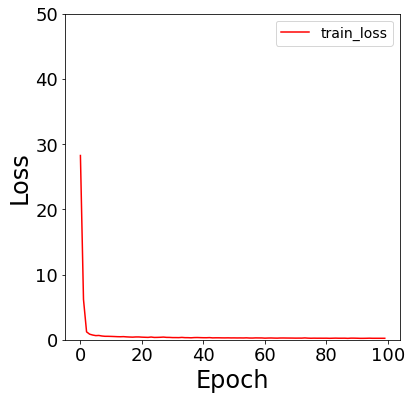

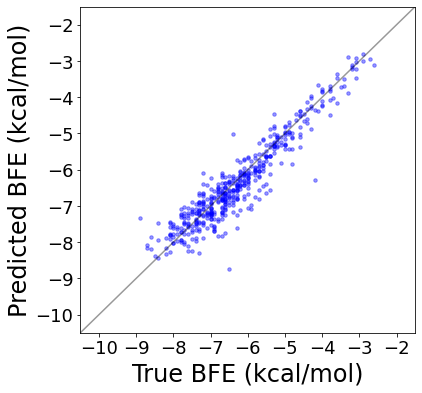

R2 : 0.88
RMSE : 0.42
MAE : 0.31


In [58]:
result_df = pd.read_json('Mpro_BFE_Result.JSON', orient='table')
i = 0
train_loss = result_df['list_train_loss'].iloc[i]
logS_total = result_df['logS_total'].iloc[i]
pred_logS_total = result_df['pred_logS_total'].iloc[0]
r_square = result_df['r_square'].iloc[i]
rmse = result_df['rmse'].iloc[i]
mae = result_df['mae'].iloc[i]

plt.rcParams["figure.figsize"] = (6, 6)
plt.ylim([0, 50])
plt.plot([e for e in range(len(train_loss))], [float(t) for t in train_loss], label="train_loss", c='red')
plt.xlabel("Epoch", fontsize=label_fs)
plt.ylabel("Loss", fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.rc('legend', fontsize=legend_fs)
plt.legend()
plt.show()

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(logS_total, pred_logS_total, s=marker_s, alpha=ap, color='blue')#, edgecolor='black')
plt.plot([-15,5], [-15,5], alpha=ap, color='black')
plt.xlim([-10.5, -1.5])
plt.ylim([-10.5, -1.5])
plt.xlabel('True BFE (kcal/mol)', fontsize=label_fs)
plt.ylabel('Predicted BFE (kcal/mol)', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.rc('legend', fontsize=legend_fs)
plt.show()

print('R2 : %.2f' % (r_square))
print('RMSE : %.2f' % (rmse))
print('MAE : %.2f' % (mae))